In [25]:
import pandas as pd
import numpy as np
import spacy
from pathlib import Path
import os
import sys
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import re
from pyvis.network import Network

# Import custom functions
cwd = Path.cwd()
one_step_up = cwd.parent
one_step_up
util_path = str(one_step_up)
sys.path.append(util_path)

from lib.utils.functions import *

### Get All Books in Witcher

In [19]:
# Put all books in a list and sort

cwd = Path.cwd()
bookdir = cwd / 'books'

# Traverse and get all names
p = Path(cwd).glob('**/*')
booklist = [x for x in p if x.is_file()]
# booklist
booklist_smaller = booklist[0:5]

In [20]:
booklist_smaller

[PosixPath('/mnt/d/Algorant/witcher_nlp/books/1 The Last Wish.txt'),
 PosixPath('/mnt/d/Algorant/witcher_nlp/books/2 The Sword of Destiny.txt'),
 PosixPath('/mnt/d/Algorant/witcher_nlp/books/3 Blood of Elves.txt'),
 PosixPath('/mnt/d/Algorant/witcher_nlp/books/4 Times of Contempt.txt'),
 PosixPath('/mnt/d/Algorant/witcher_nlp/books/5 Baptism of Fire.txt')]

### Load and Filter Characters

In [21]:
# Load Character dfs
charpath = one_step_up / 'characters'
characters = pd.read_csv(f"{charpath}/characters.csv")
# Remove brackets and text within brackets using regex
characters['character'] = characters['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
# If name is split, ie Geralt of Rivia, get only first part
characters['character_firstname'] = characters['character'].apply(lambda x: x.split(' ', 1)[0])
# Make exception for "Two Tusks", because first name of "Two" causes problems
characters['character_firstname'] = characters['character_firstname'].replace(['Two'], 'Two Tusks')

### Iterate through all books and create graphs

In [22]:
books_graph = []

for book in booklist_smaller:
    book_text = textproc(book)
    
    # Get list of entities per sentence
    sent_entity_df = get_sentence_entities(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters))
    
    # Filter out sentences that don't have character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take out first names
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
                                                                                                                  for item in x])
    # Create relationship df
    relationships = create_relationships(df = sent_entity_df_filtered, window_size = 5)
    
    # Create network graph from df
    
    G = nx.from_pandas_edgelist(relationships,
                                source = "source",
                                target = "target",
                                edge_attr = "value",
                                create_using = nx.Graph())
    
    books_graph.append(G)
    

/tmp/ipykernel_11885/2137085401.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/tmp/ipykernel_11885/2137085401.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/tmp/ipykernel_11885/2137085401.py:16: SettingWithCopyWarning: 
A value is trying to be 

### Testing with 5 books

<AxesSubplot:>

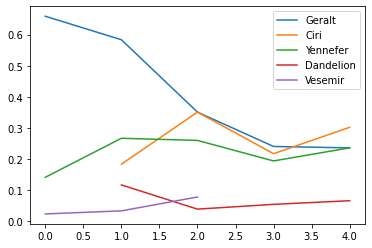

In [23]:
evol = [nx.degree_centrality(book) for book in books_graph]

degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting Centrality of Main Characters

degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()

### Making Community Graph again with 5 books

In [27]:
net = Network(notebook=True, width="1000px", height="700px", bgcolor="#222222", font_color="white")

# Make node size relative
node_degree = dict(G.degree)

# Setting up node size
nx.set_node_attributes(G, node_degree, "size")

# Pass in networkx Graph G
net.from_nx(G)
net.show("witcher.html")

In [28]:
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#00000F', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")